In [1]:
from ast import boolop
import torch
import torch.nn as nn

from sklearn.neural_network import MLPClassifier
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
import os
import sys
import argparse
import pickle
import numpy as np
import pandas as pd

import configparser
import argparse
import textwrap

from model_utils import *
from data_utils import _make_dataset
from gaussian import Gaussian

import dice
import gradual_construction
from bayes_cf import *
import face_knn

In [2]:
german = pd.read_csv("../data/datasets/german_credit/german_numeric.data")

In [3]:
protect_idx = german[german['Foreign worker'] == 'yes'].index

In [4]:
config = configparser.ConfigParser()
config.read('german.config')
basic_config = config['Basic']
classifier_config = config['Classifier']
data_config = config['Data']
vae_config = config['Vae']
dice_config = config['DiCE']
bayes_config = config['Bayes']
grad_con_config = config['GradualConstruction']
face_config = config['FACE']

In [5]:
data = _make_dataset(
            fname=basic_config['dataset_path'],
            dag_fname = basic_config['dag_path'],
            softmax_temp = float( data_config['softmax_temp'] ),
            target_column=data_config['target_column'],
            drop_columns=eval( data_config['drop_columns'] ),
            set_na = eval( data_config['set_na'] ),
            immutable_columns = eval( data_config['immutable_columns'] ),
            nonactionable_columns = eval( data_config[ 'nonactionable_columns' ] ),
            log_transform = eval( data_config[ 'log_transform' ] ),
            dataset=basic_config['dataset'],
    )
X = data[:][0] #Get preprocessed data
y = data[:][1] #Get preprocessed labels
X_women = X[data.protect_list]
y_women = y[data.protect_list]
X_men = X[~data.protect_list]
y_men = y[~data.protect_list]

No DAG file provided/DAG path does not exist


In [14]:
use_X = pd.DataFrame(X.numpy())
def generator_small(data_dim):
    model = Sequential()
    
    model.add(Dense(128, input_dim=data_dim))
    model.add(Activation('relu'))
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dense(data_dim))
    
    return model

def whiten_german(data, mu, sigma, dis):
    new_df = pd.DataFrame(data.copy(), columns = list(range(data.shape[1])))
    for col in new_df.columns:
        if col in ['0', 0]:
            new_df[col] = np.log(new_df[col] + 10e-6) 
    for col in new_df.columns:
        new_df[col] = new_df[col] - mu[col]
        if sigma[col] > 0:
            new_df[col] = new_df[col] / sigma[col]
    return new_df

def dewhiten(data, mu, sigma, dis):
    new_df = pd.DataFrame(data.copy(), columns = list(range(data.shape[1])))
    for col in new_df.columns:
        if sigma[col] > 0:
            new_df[col] = new_df[col] * sigma[col]
        new_df[col] = new_df[col] + mu[col]
    for col in new_df.columns:
        if col in ['0', 0]:
            new_df[col] = np.exp(new_df[col]) - 10e-6
        if str(col) in dis or col in [2,3,5,6]:
            new_df[col] = np.round(new_df[col])
    return new_df

In [15]:
with open("german_dwa.pk", 'rb') as f:
    dwa_args = pickle.load(f)
G = generator_small(X.shape[1])
G.load_weights('german_gan')
whiten = whiten_german

In [16]:
def pred(X):
    return torch.tensor(dewhiten(G.predict(whiten(X, **dwa_args)), **dwa_args).to_numpy())

In [17]:
if classifier_config["classifier"] == "Logistic_Regression":
    classifier = LogisticRegression()
    if y.shape[1] > 1:
        # If one-hot encoding labels, pass labels as the argmax
        classifier.create_model( X.detach(), torch.argmax( y, axis=1 ) )
    else:
        classifier.create_model( X.detach(), y.ravel() ) 

In [18]:
assert german.shape[0] == X.shape[0]

In [19]:
german['pred'] = np.argmax(classifier(X).detach().numpy(), axis=1)

In [20]:
german['paired_pred'] = np.argmax(classifier(pred(X.numpy())).detach().numpy(), axis=1)

In [21]:
protec = german[german['Foreign worker'] == 'yes']

In [22]:
bad_real = protec[protec['pred'] == 0]

In [23]:
bad_both = bad_real[bad_real['paired_pred'] == 0]

In [24]:
bad_both.index

Int64Index([  1,  11,  35,  59,  63,  69, 101, 116, 134, 145, 152, 191, 194,
            230, 242, 272, 286, 332, 359, 467, 476, 616, 637, 639, 677, 685,
            706, 714, 787, 789, 814, 829, 887, 938, 973, 998, 999],
           dtype='int64')

In [3]:
with open("German_Credit_Bayes_Credit amount_disps.pk", 'rb') as f:
    bayes_we = np.array(pickle.load(f))
with open("German_Credit_face_Credit amount_disps.pk", 'rb') as f:
    face_we = np.array(pickle.load(f))
with open("German_Credit_DiCE_Credit amount_disps.pk", 'rb') as f:
    DiCE_we = np.array(pickle.load(f))

with open("German_Credit_Bayes_Age in years_disps.pk", 'rb') as f:
    bayes_hl = np.array(pickle.load(f))
with open("German_Credit_face_Age in years_disps.pk", 'rb') as f:
    face_hl = np.array(pickle.load(f))
with open("German_Credit_DiCE_Age in years_disps.pk", 'rb') as f:
    DiCE_hl = np.array(pickle.load(f))

In [4]:
import matplotlib.pyplot as plt

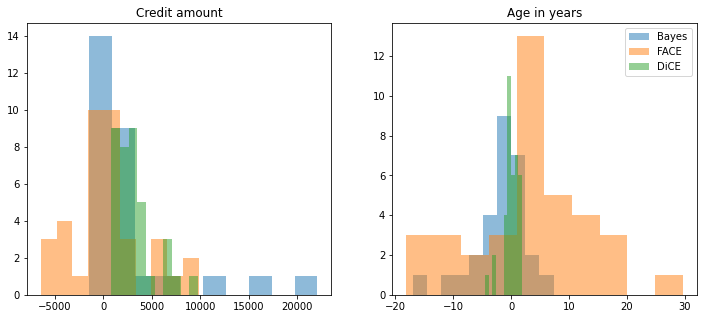

In [6]:
fig, ax = plt.subplots(ncols=2, constrained_layout=False, figsize=(12,5))
ax[0].hist(bayes_we, label = 'Bayes', alpha=0.5)
ax[0].hist(face_we, label = 'FACE',alpha=0.5)
ax[0].hist(DiCE_we, label = 'DiCE',alpha=0.5)
ax[0].set_title("Credit amount")
ax[1].hist(bayes_hl, label = 'Bayes',alpha=0.5)
ax[1].hist(face_hl, label = 'FACE',alpha=0.5)
ax[1].hist(DiCE_hl, label = 'DiCE',alpha=0.5)
ax[1].set_title("Age in years")
plt.legend()
plt.savefig("german_graphs.pdf")